In [22]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
from utils_ecoli import *
from GSMM import *
from models_MWCq import *
check_device()
print(models_)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is not available.
+--------------+-----------------------+
| ORGANISM     | MODEL_SBML            |
+==============+=======================+
| ECOLI_core   | e_coli_core_SBML3.xml |
+--------------+-----------------------+
| mus_musculus | mus_iMM1415.xml       |
+--------------+-----------------------+
| homo_sapiens | Recon3D.xml           |
+--------------+-----------------------+


In [23]:
data_path = os.path.abspath('../data/e_coli_data/original/')
metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'), index_col = 0)
metadata.drop(metadata.index[236:240], axis=0, inplace = True)

#load augmented data and prepross feat 
data_path = os.path.abspath('./../data/e_coli_data/augmented')

data_dict = pk_load(os.path.join(data_path, 'aug_data_dict.pk'))
data = list(data_dict.values())[0]
R = list(data_dict.values())[1]
srm = list(data_dict.values())[2]

combined_outs = pk_load(os.path.join(data_path, 'combined_outs.pk'))
bounds = combined_outs['bounds']
mw_nodes = combined_outs['mw_nodes']
gt_clique_obj = combined_outs['gt_clique_obj']
RES_b = combined_outs['RES_b']
RES_c = combined_outs['RES_c']

loading e_coli_core_SBML3.xml...
137 genes
72 metabolites
95 reactions with bound max 1000


,count,mean,std,min,25%,50%,75%,max
0,95.0,22.21,17.8,1.0,3.5,18.0,40.0,58.0


graph with 95 nodes, 1055 edges
is directed: False
is connected: False connected subgraphs: 2
has self loops: False


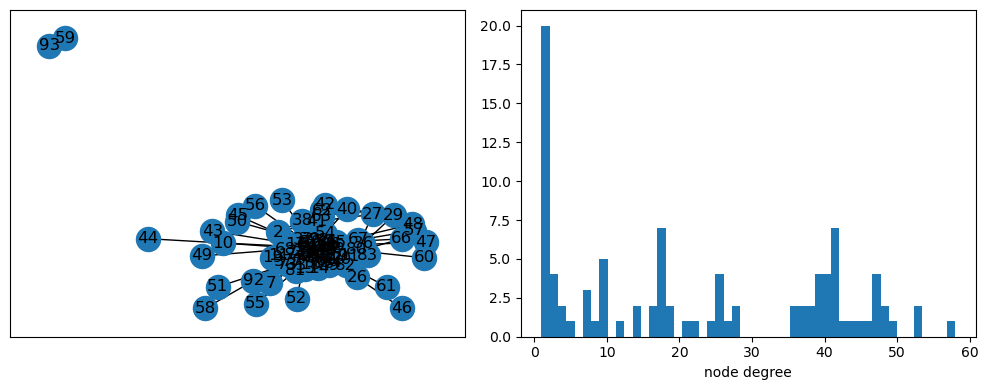

In [24]:
#load model

models_dir = os.path.abspath('../src/sbml_models/')
organism = "ECOLI_core"
sbml_file = libsbml.readSBMLFromFile(os.path.join(models_dir, models[organism]))

gene_exp_scale = 10
bound_max = 1000
model = metabolic_model(organism, sbml_file, bound_max=bound_max)
m_model = model


#get GSMM graph params
S = model.S
S_matrix = model.S_matrix
reactions = list(model.reactions.keys())
metabolites = list(model.metabolites.keys())

S_bool = np.array(S_matrix.astype('bool').astype('int'))
RAG = np.matmul(S_bool.T, S_bool)
adj = RAG.astype('bool').astype('int') 
adj = adj - np.identity(adj.shape[0]) #remove self loops ##symmetric boolean adj matrix
A = sp.csr_matrix(adj)
G = nx.from_scipy_sparse_array(A)

degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
nx.draw_networkx(G, ax = ax)
ax = axes[1]
ax.hist(degrees, bins=50)
ax.set_xlabel("node degree")
fig.tight_layout()


print(f'graph with {len(G.nodes)} nodes, {len(G.edges)} edges')
print(f'is directed: {G.is_directed()}')
print(f'is connected: {nx.is_connected(G)}', 
      f'connected subgraphs: {len([G.subgraph(c).copy() for c in nx.connected_components(G)])}')
print(f'has self loops: {any(G.has_edge(node, node) for node in G.nodes)}')

## Max Wt Clique Prediction

In [25]:
graph = base_graph(G, m_model)
graph.get_input_features(srm, R) 

In [26]:
total_samples = len(graph.f)
psd_features = []
sctdataset = []

for s in range(total_samples):
    feat = graph.f[s]
    data = Data(x=np.array(feat),edge_index=graph.edge_index)
    psd_features += (data.x.tolist())
    sctdataset += [data]



num_trainpoints = int(np.floor(0.6*total_samples))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = total_samples - (num_trainpoints + num_valpoints)
traindata= sctdataset[0:num_trainpoints]
valdata = sctdataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = sctdataset[num_trainpoints + num_valpoints:]
print(len(traindata))
print(len(valdata))
print(len(testdata))

batch_size = 80

def my_collate(batch):
    data = [item for item in batch]
    return data
train_loader = DataLoader(traindata, batch_size, shuffle=True,collate_fn=my_collate)
test_loader = DataLoader(testdata, batch_size, shuffle=False,collate_fn=my_collate)
val_loader =  DataLoader(valdata, batch_size, shuffle=False,collate_fn=my_collate)

1808
602
604


init model; total number of parameters: 793
Epoch:-----0
Epoch:-----1
Epoch:-----2


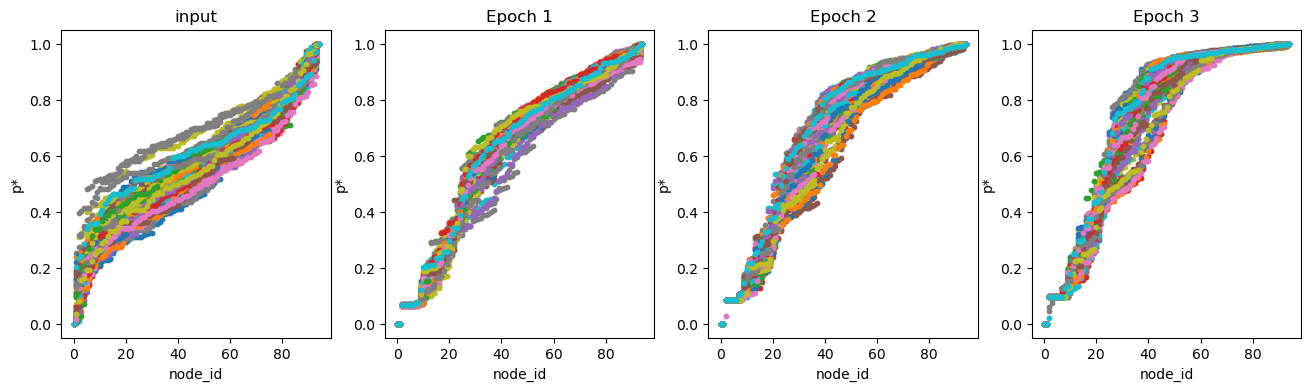

In [34]:
'''
model params
--------------------------------------------------------------------------------
'''

torch.manual_seed(1)
order = 3
N = 95
penalty_coefficient = 0.5
lr = 1e-4
wt_decay = 0

'''
init
--------------------------------------------------------------------------------
'''
    
model = scattering_GNN(graph,
                    input_dim =4, 
                hidden_dim=8, 
                output_dim=1, 
                n_layers=3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wt_decay) 

'''
train
--------------------------------------------------------------------------------
'''


EPOCHS = 3

#progress
fig, axes = plt.subplots(1, (EPOCHS+1), figsize = ((EPOCHS+1)*4,4))
td = [[i,batch] for i, batch in enumerate(train_loader)]
batch = td[0][1]
plot_support(model, batch, ax=axes[0])
axes[0].set_title(f'input')

for i in range(EPOCHS):
    train(model, i, train_loader, optimizer, penalty_coefficient, verbose=False)
    
    td = [[i, batch] for i, batch in enumerate(train_loader)]
    batch = td[0][1]
    
    # Pass the subplot axes as an argument to the plot_support function
    plot_support(model, batch, ax=axes[i + 1])
    axes[i + 1].set_title(f'Epoch {i + 1}')

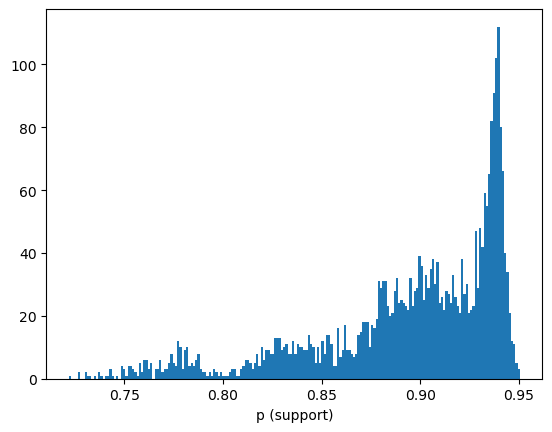

In [47]:
model.eval()
mwc_res = []
for d in sctdataset:
    features = torch.FloatTensor(d.x)
    output_dis = model(features)
    outs = output_dis.detach().numpy().reshape(-1,)
    mwc_res += [outs]



res = pd.DataFrame(mwc_res)
res.index = srm.index
res.columns = srm.columns

plt.hist(np.median(res, axis = 1), bins = 200)
plt.xlabel('p (support)')
plt.show()


In [ ]:

# colors = ["#ACAAE1", "#328CD7", "#DA9D8D", "#D82C0A",'#164B41', "#00997B", "#824B77", "#861A22",'#ECF229',
#           "#4146A6", "#8BBF56",'#C9E7F2',"#A65233","#353273", "#F2C84B", "#261810",'#BF4B8B',"#D996B5","#D9D9D9","#B9BF04","#4C1B33",'#96B9D9',"#F27D16","#09577B"
#           ]

# metadata_dict = {'sample_group': metadata['Condition ID'].astype('str'),
# 'carbon' : metadata['Carbon Source (g/L)'].astype('str'),
# 'nitrogen' : metadata['Nitrogen Source (g/L)'].astype('str'),
# 'electron_acc' : metadata['Electron Acceptor'].astype('str'),
# 'growth_rate' : metadata['Growth Rate (1/hr)']
# }

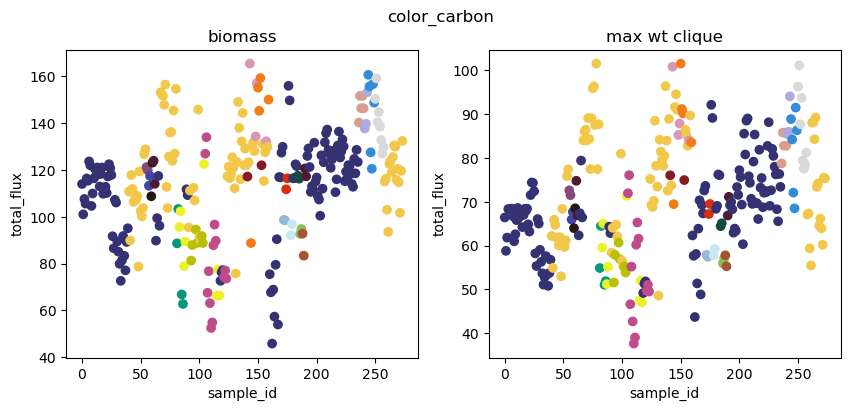

In [ ]:
# #c_feats ['sample_group', 'carbon', 'nitrogen', 'electron_acc', 'growth_rate']
# c_feat = 'carbon'

# #total flux
# a = [np.sum(r.x) for r in RES_clique]
# b= [np.sum(r.x) for r in RES_bio]
# y_feat = [a,b]
# plot_metadata(y_feat, c_feat, metadata_dict, colors, 'total_flux')